In [ ]:
import nltk
nltk.download('stopwords') 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import re, numpy as np, pandas as pandas
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

#NLTK stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
import pandas as pd 
df = pd.read_csv("google_reviews_dataset.csv")
df

,User_name,User_type,Reviews,Review_Duration,User_reviews
0,Ketan Chothe,Local Guide,· 264 reviews,6 months ago,Good Outlet in hub mall near Western express h...
1,Janhavi Raut,Local Guide,· 88 reviews,6 months ago,Satisfied with their services.....staff is co ...
2,Divye Panchal ADivyzz,Local Guide,· 41 reviews,2 months ago,Food was like as MacD but freshness was missin...
3,Yummy Destination,Local Guide,· 73 reviews,a year ago,Had a great experience at this Mc.Donalds outl...
4,Shubham Marda,Local Guide,· 154 reviews,a month ago,"Great atmosphere, balcony kind of seating, nic..."
...,...,...,...,...,...
460,Manish Agravat,Local Guide,1 review,a year ago,Hub store McDonald's is great place
461,Neha iyer,Local Guide,· 67 reviews,3 years ago,"THE FOOD ,THE COFEE AEWSOME, ITS WONDERFUL SHO..."
462,Celina Daniel,Local Guide,1 review,2 years ago,The food and ambience is worth hanging around ...
463,rehan akhtar,Local Guide,· 425 reviews,4 years ago,On Western highway in hub mall. Seating are go...


In [ ]:
def sent_to_words(sentences):
  for sent in sentences:
    sent = re.sub('\s+', ' ', str(sent)) #remove new line chars
    sent = re.sub("\'", " ", str(sent)) #remove single quotes
    sent = gensim.utils.simple_preprocess(str(sent), deacc=True)
    yield(sent)

In [ ]:
# Convert to list
All_reviews = df.User_reviews.values.tolist()
reviews_words = list(sent_to_words(All_reviews))
print(reviews_words[:1])


[['good', 'outlet', 'in', 'hub', 'mall', 'near', 'western', 'express', 'highway', 'ambience', 'is', 'good', 'they', 'open', 'till', 'midnight', 'am', 'they', 'have', 'good', 'seating', 'arrangements', 'inside', 'outlet', 'also', 'they', 'have', 'slef', 'order', 'machine', 'can', 'place', 'order', 'pay', 'take', 'order', 'from', 'counter']]


In [ ]:
!pip install spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Build Bigram, Trigram model**

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(reviews_words, min_count=5, threshold=10)
trigram = gensim.models.Phrases(bigram[reviews_words], threshold=10)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.9/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
  """Remove stopwords. form bigrams, trigrams and lemmatization"""
  texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
  texts = [bigram_mod[doc] for doc in texts]
  texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
  texts_out = []
  nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
  for sent in texts:
    doc = nlp(" ".join(sent))
    texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
  #remove stopwords once more after lemmatization
  texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]
  return texts_out

In [ ]:
data_final = process_words(reviews_words) #processed reviews data


In [ ]:
print(data_final)

[['ambience', 'good', 'open', 'midnight', 'good', 'seating', 'arrangement', 'also', 'slef', 'order', 'machine', 'place', 'order', 'pay', 'take', 'order', 'counter'], ['satisfied', 'service', 'staff', 'also', 'polite', 'get', 'order', 'minute', 'rush', 'obviously', 'delay', 'overall', 'experience', 'excellent', 'need', 'wait', 'order', 'counter'], ['food', 'macd', 'freshness', 'miss', 'somewhere'], ['great', 'experience', 'mc', 'donald', 'locate', 'ground', 'floor', 'quite', 'large', 'ambience', 'great'], ['great', 'atmosphere', 'balcony', 'kind', 'seat', 'nice', 'staff', 'really', 'njoye'], ['happen', 'place', 'whole', 'mall', 'situate', 'main', 'highway', 'almost', 'full', 'everyday', 'taste', 'quite', 'different', 'store', 'service', 'good', 'also', 'table', 'service', 'option', 'available', 'store'], ['place', 'crowd'], ['make', 'wait', 'minute', 'milkshake', 'else', 'even', 'line', 'absolute', 'terrible', 'service', 'people', 'work', 'joke', 'woman', 'take', 'order', 'counter', 'gr

## **Build a LDA Topic Model**

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_final)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_final]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                            id2word = id2word,
                                            num_topics= 7,
                                            random_state = 100,
                                            update_every = 1,
                                            chunksize = 10,
                                            passes = 10,
                                            alpha = 'symmetric',
                                            iterations = 100,
                                            per_word_topics = True)
pprint(lda_model.print_topics())

[(0,
  '0.057*"place" + 0.054*"order" + 0.050*"good" + 0.044*"time" + 0.027*"new" + '
  '0.023*"get" + 0.022*"enjoy" + 0.022*"worth" + 0.021*"much" + 0.020*"hang"'),
 (1,
  '0.219*"good" + 0.072*"service" + 0.048*"always" + 0.039*"quick" + '
  '0.028*"love" + 0.026*"store" + 0.025*"high" + 0.020*"bite" + 0.019*"price" '
  '+ 0.014*"taste"'),
 (2,
  '0.084*"well" + 0.033*"outlet" + 0.030*"quality" + 0.028*"coffee" + '
  '0.022*"item" + 0.021*"sell" + 0.020*"otherwise" + 0.019*"totally" + '
  '0.017*"want" + 0.017*"aloo"'),
 (3,
  '0.057*"burger" + 0.056*"also" + 0.035*"visit" + 0.033*"ambience" + '
  '0.032*"quite" + 0.031*"hub_mall" + 0.028*"drive" + 0.024*"serve" + '
  '0.020*"yummy" + 0.019*"kid"'),
 (4,
  '0.085*"service" + 0.043*"staff" + 0.040*"fry" + 0.039*"usual" + '
  '0.038*"mcdonald" + 0.031*"fast" + 0.029*"experience" + 0.029*"slow" + '
  '0.020*"bit" + 0.018*"standard"'),
 (5,
  '0.144*"food" + 0.079*"great" + 0.073*"nice" + 0.029*"seat" + 0.020*"really" '
  '+ 0.019*"disco

## **Word Clouds of Top N Keywords in Each Topic**

In [ ]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(stopwords = stop_words,
                  background_color = 'white',
                  width = 2500,
                  height = 1800,
                  max_words = 10,
                  colormap = 'tab10',
                  color_func = lambda *args, **kwargs: cols[i],
                  prefer_horizontal = 1.0)

topics = lda_model.show_topics(formatted=False)


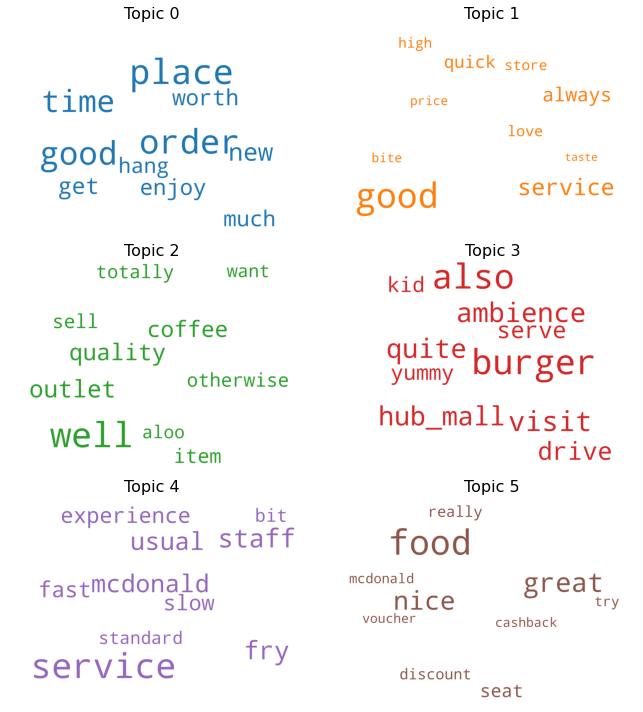

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
  fig.add_subplot(ax)
  topic_words = dict(topics[i][1])
  cloud.generate_from_frequencies(topic_words, max_font_size=300)
  plt.gca().imshow(cloud)
  plt.gca().set_title('Topic '+str(i), fontdict=dict(size=16))
  plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
word_dict = {};
for i in range(7):
  words = lda_model.show_topic(i, topn = 20)
  word_dict['Topic # ' + '{:02d}'.format(i)] = [i[0] for i in words]
pd.DataFrame(word_dict)

,Topic # 00,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06
0,place,good,well,burger,service,food,place
1,order,service,outlet,also,staff,great,hangout
2,good,always,quality,visit,fry,nice,go
3,time,quick,coffee,ambience,usual,seat,crowd
4,new,love,item,quite,mcdonald,really,wonderful
5,get,store,sell,hub_mall,fast,discount,ever
6,enjoy,high,otherwise,drive,experience,try,never
7,worth,bite,totally,serve,slow,mcdonald,fresh
8,much,price,want,yummy,bit,cofee,bad
9,hang,taste,aloo,kid,standard,cashback,friend


In [ ]:
# Get topic weights and dominant topics 
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show 
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights 
topic_weights = [] 
for i, row_list in enumerate(lda_model [corpus]): 
  topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights
arr = pd.DataFrame(topic_weights).fillna(0).values

#Keep the well separated points (optional) 
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc 
topic_num= np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE (n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda= tsne_model.fit_transform(arr)

# Plot the topic clusters using Bokeh
output_notebook()
n_topics = 7
mycolors= np.array([color for name, color in mcolors.TABLEAU_COLORS.items()]) 
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=600, plot_height=400)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num]) 
show(plot)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 382 samples in 0.001s...
[t-SNE] Computed neighbors for 382 samples in 0.041s...
[t-SNE] Computed conditional probabilities for sample 382 / 382
[t-SNE] Mean sigma: 0.181036
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.457123
[t-SNE] KL divergence after 1000 iterations: 0.478570


In [ ]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 37.3 MB/s eta 0:00:00


In [ ]:
import pyLDAvis.gensim 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word) 
vis

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.057116  0.040446       1        1  18.082575
1     -0.265143 -0.027682       2        1  17.312249
5      0.139128 -0.217534       3        1  15.182675
3      0.113116  0.217176       4        1  15.140776
4     -0.033941 -0.016242       5        1  12.896279
6      0.058200 -0.004615       6        1  11.268930
2      0.045757  0.008452       7        1  10.116516, topic_info=            Term        Freq       Total Category  logprob  loglift
4           good  211.000000  211.000000  Default  30.0000  30.0000
28          food   99.000000   99.000000  Default  29.0000  29.0000
10         place  123.000000  123.000000  Default  28.0000  28.0000
25       service  106.000000  106.000000  Default  27.0000  27.0000
35         great   55.000000   55.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
216       indian    3.897724    7.466207   Topic7  -4.7618   1.6410
1130      useful    3.549039    7.323364   Topic7  -4.8555   1.5666
1071      veggie    2.120545    3.487692   Topic7  -5.3705   1.7934
1136     pricing    4.251105   14.715594   Topic7  -4.6750   1.0493
1131  punishment    2.395991    7.398686   Topic7  -5.2484   1.1635

[271 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
667       1  0.725469    actually
667       3  0.120911    actually
667       7  0.120911    actually
771       6  0.910002  affordable
1068      7  0.884592        aloo
...     ...       ...         ...
920       6  0.953205   wonderful
78        3  0.850040        work
623       1  0.960512       worth
347       5  0.778155       write
931       4  0.903931       yummy

[269 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 6, 4, 5, 7, 3])